## Pre-processing

### Table of Contents
- Introduction
- Import and Load Cleaned Data
- Feature Engineering
- Total Passengers
- Stationarity
- ACF and PACF Plots
- Conclusion / Next Steps
- Export Files

### Introduction
Now that we have explored and analyzed the dataset, it's time to pre-process the dataset for modeling. Before getting into pre-processing the dataset, feature engineering will be done to transform it into a more effective set of inputs for time series modeling. As we have deduced, there is seasonal component to the dataset and thus Seasonal Auto-Regressive Integrated Moving Average (SARIMA) model will be used. To pre-process for the SARIMA model, its decomposition will be analyzed, stationarity will be checked, and autocorrelation (ACF) & partial autocorrelation functions will be plotted.

### Import and Load Cleaned Data

We will add some statsmodels libraries onto the list of imported libraries to utilize during this pre-processing phase.

In [1]:
# import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import datetime as dt
import statsmodels.api as sm
from statsmodels.api import tsa
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller


Load in the cleaned dataset from before and check to see everything is in order.

In [2]:
# load in cleaned dataset
df = pd.read_csv('capstone_data_cleaned.csv')
df['DATE'] = pd.to_datetime(df['DATE'])
df1 = df.copy()
df.set_index('DATE', inplace=True)

In [3]:
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 390469 entries, 2013-01-01 to 2024-05-01
Data columns (total 13 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   DEPARTURES_PERFORMED  390469 non-null  float64
 1   SEATS                 390469 non-null  float64
 2   PASSENGERS            390469 non-null  float64
 3   CARRIER               390435 non-null  object 
 4   CARRIER_NAME          390469 non-null  object 
 5   ORIGIN_AIRPORT_ID     390469 non-null  int64  
 6   ORIGIN_CITY_NAME      390469 non-null  object 
 7   ORIGIN_COUNTRY_NAME   390469 non-null  object 
 8   DEST_AIRPORT_ID       390469 non-null  int64  
 9   DEST_CITY_NAME        390469 non-null  object 
 10  DEST_COUNTRY_NAME     390469 non-null  object 
 11  YEAR                  390469 non-null  int64  
 12  MONTH                 390469 non-null  int64  
dtypes: float64(3), int64(4), object(6)
memory usage: 41.7+ MB
None


DEPARTURES_PERFORMED    SEATS  PASSENGERS CARRIER  \
DATE                                                            
2013-01-01                   1.0    526.0       483.0      LH   
2013-01-01                  31.0  10848.0      7555.0      LH   
2013-01-01                  10.0    370.0       259.0      MQ   
2013-01-01                  10.0    440.0       253.0      MQ   
2013-01-01                  31.0  10726.0      4944.0      MS   

                            CARRIER_NAME  ORIGIN_AIRPORT_ID  \
DATE                                                          
2013-01-01     Lufthansa German Airlines              13303   
2013-01-01     Lufthansa German Airlines              11618   
2013-01-01  American Eagle Airlines Inc.              11298   
2013-01-01  American Eagle Airlines Inc.              12953   
2013-01-01                      Egyptair              12478   

                 ORIGIN_CITY_NAME ORIGIN_COUNTRY_NAME  DEST_AIRPORT_ID  \
DATE                                                                     
2013-01-01              Miami, FL       United States            10970   
2013-01-01             Newark, NJ       United States            11760   
2013-01-01  Dallas/Fort Worth, TX       United States            14879   
2013-01-01           New York, NY       United States            16217   
2013-01-01           New York, NY       United States            10872   

                     DEST_CITY_NAME DEST_COUNTRY_NAME  YEAR  MONTH  
DATE                                                                
2013-01-01         Cologne, Germany           Germany  2013      1  
2013-01-01       Frankfurt, Germany           Germany  2013      1  
2013-01-01  San Luis Potosi, Mexico            Mexico  2013      1  
2013-01-01         Montreal, Canada            Canada  2013      1  
2013-01-01             Cairo, Egypt             Egypt  2013      1

### Feature Engineering

In order to forecast popular destinations based on time series modeling, only three variables will be needed: `DATE`, `DEST_CITY_NAME`, and `PASSENGERS`. `DATE` will become the index of the newly transformed dataframe, leaving `DEST_CITY_NAME` and `PASSENGERS` as feature and target, respectively. Although it looks like there is one feature and one target, each destination will become a feature; therefore, the dataframe will be transformed to have multiple features. At the start we saw there were 171 different destinations in the dataset, which means 171 features to model and analyze! Through feature engineering, we can narrow this down to a sizable amount for modeling and analysis.

First step will be to set a minimum threshold on the number of passengers. It would not be relevant to evaluate destinations with under 100 passengers a month to destinations with 10,000 passengers a month.

In [4]:
# group the dataset by destination and sum of passengers
df_dest = df1.copy()
df_dest = df_dest[['DATE', 'PASSENGERS','DEST_CITY_NAME']].groupby(['DATE','DEST_CITY_NAME'], as_index=False)['PASSENGERS'].sum().sort_values(by=['DATE','PASSENGERS'], ascending=[True,False])
df_dest['DATE'] = pd.to_datetime(df_dest['DATE'])
df_dest

DATE              DEST_CITY_NAME  PASSENGERS
116   2013-01-01      London, United Kingdom    517423.0
226   2013-01-01             Toronto, Canada    422479.0
224   2013-01-01                Tokyo, Japan    373605.0
39    2013-01-01              Cancun, Mexico    247724.0
135   2013-01-01         Mexico City, Mexico    240324.0
...          ...                         ...         ...
35174 2024-05-01               Gerona, Spain         1.0
35188 2024-05-01            Hamburg, Germany         1.0
35196 2024-05-01  Humberside, United Kingdom         1.0
35228 2024-05-01              Macapa, Brazil         1.0
35373 2024-05-01             Zaragoza, Spain         1.0

[35375 rows x 3 columns]

In [5]:
# top '10' destinations each month every year
top_dest = df_dest.groupby(['DATE']).apply(lambda x: x.head(10)).reset_index(drop=True)
top_dest

DATE          DEST_CITY_NAME  PASSENGERS
0    2013-01-01  London, United Kingdom    517423.0
1    2013-01-01         Toronto, Canada    422479.0
2    2013-01-01            Tokyo, Japan    373605.0
3    2013-01-01          Cancun, Mexico    247724.0
4    2013-01-01     Mexico City, Mexico    240324.0
...         ...                     ...         ...
1365 2024-05-01      Frankfurt, Germany    354768.0
1366 2024-05-01     Mexico City, Mexico    347926.0
1367 2024-05-01       Vancouver, Canada    311201.0
1368 2024-05-01  Amsterdam, Netherlands    302083.0
1369 2024-05-01      Seoul, South Korea    284783.0

[1370 rows x 3 columns]

In [6]:
# find the minimum passenger in the monthly top 10 destination
top_dest[top_dest['PASSENGERS'] == top_dest['PASSENGERS'].min()]

DATE  DEST_CITY_NAME  PASSENGERS
889 2020-05-01  Taipei, Taiwan      5407.0

Using the top 10 monthly destinations in the past decade as a basis, Taipei had the lowest amount of passengers at one point with 5,407. This will be the minimum threshold.

With the minimum threshold set, we can narrow it down further to destinations that have less than 12 months of data points missing. By setting the minimum threshold on `PASSENGERS`, this would have caused to include some destinations if they had more than 5,407 passengers even at least once. Continuity of data points is required for time series modeling later on so destinations with only one data point or even few data points would be useless. Furthermore, less than 12 months is selected on the basis of COVID lockdown. The longest cumulative COVID lockdown was about 9-10 months and so for ease of interpretation we will cap it at 12 months.

In [7]:
# filter the main dataframe with passengers greater than the minimum threshold
df_min = df_dest[df_dest['PASSENGERS'] > top_dest['PASSENGERS'].min()]

# keep the cities with date points missing less than 12 months
df_keep = df_min[df_min['DEST_CITY_NAME'].map(df_min['DEST_CITY_NAME'].value_counts()) > 125]

df_keep['DEST_CITY_NAME'].value_counts()

DEST_CITY_NAME
London, United Kingdom    137
Tokyo, Japan              137
Guadalajara, Mexico       137
Mexico City, Mexico       137
Frankfurt, Germany        137
                         ... 
Munich, Germany           128
Madrid, Spain             128
Dublin, Ireland           127
Cozumel, Mexico           127
Cartagena, Colombia       127
Name: count, Length: 61, dtype: int64

After filtering the dataset, we have narrowed it down to 61 different destinations. Seems more manageable than 171 destinations. From Jan 2013 to May 2024, there should be 137 months. We can see, possibly due to COVID lockdown or other factors, there are some destinations with missing data points. The greatest amount missing is 10 months which is a small percentage of the total and so we can use the `interpolate` function to fill in the values as shown by the function below.

In [8]:
def fill_dates(city):
    '''
    Inputs the monthly number of passengers of a destination and checks for continuity of the datapoints from 2013-01-01 to 2024-05-01.
    Fills in any missing dates by interpolation.

    Input
    -----
    Destination
    
    Output
    ------
    Dataframe interpolated with no missing datapoints
    '''

    df_city = df_dest[df_dest['DEST_CITY_NAME']==city].drop(columns='DEST_CITY_NAME').set_index('DATE').asfreq('MS')
    
    if df_city['PASSENGERS'].isna().sum() > 0:
        df_city['PASSENGERS'] = df_city['PASSENGERS'].interpolate(method='time')
        df_city.rename(columns={'PASSENGERS': city}, inplace=True)
    else:
        df_city.rename(columns={'PASSENGERS': city}, inplace=True)


    return df_city

In [9]:
# combine the monthly number of passengers of all the destinations into one dataframe as the main working dataframe
df_main = []
city_list = df_keep['DEST_CITY_NAME'].unique()
for cl in range(len(city_list)):
    df_main.append(fill_dates(city_list[cl]))
df_main = pd.concat(df_main, axis=1)
df_main.head()

London, United Kingdom  Toronto, Canada  Tokyo, Japan  \
DATE                                                                
2013-01-01                517423.0         422479.0      373605.0   
2013-02-01                411641.0         387761.0      349596.0   
2013-03-01                567949.0         501870.0      407785.0   
2013-04-01                644073.0         489343.0      319277.0   
2013-05-01                733345.0         525027.0      386794.0   

            Cancun, Mexico  Mexico City, Mexico  Frankfurt, Germany  \
DATE                                                                  
2013-01-01        247724.0             240324.0            201467.0   
2013-02-01        264890.0             187736.0            167323.0   
2013-03-01        341747.0             218482.0            232239.0   
2013-04-01        261987.0             214770.0            252450.0   
2013-05-01        269585.0             218376.0            330027.0   

            Seoul, South Korea  Paris, France  Vancouver, Canada  \
DATE                                                               
2013-01-01            198960.0       184354.0           166967.0   
2013-02-01            171938.0       155640.0           159644.0   
2013-03-01            189145.0       224858.0           184465.0   
2013-04-01            168312.0       241892.0           176490.0   
2013-05-01            211726.0       310115.0           194628.0   

            Sao Paulo, Brazil  ...  Medellin, Colombia  \
DATE                           ...                       
2013-01-01           144062.0  ...             14570.0   
2013-02-01           123352.0  ...             11639.0   
2013-03-01           116173.0  ...             11895.0   
2013-04-01           115089.0  ...             11775.0   
2013-05-01           129122.0  ...             12330.0   

            Leon/Guanajuato, Mexico  Guayaquil, Ecuador  \
DATE                                                      
2013-01-01                  14359.0             14119.0   
2013-02-01                  10473.0             16449.0   
2013-03-01                  14012.0             16613.0   
2013-04-01                  12619.0             17531.0   
2013-05-01                  13199.0             18738.0   

            Puerto Plata, Dominican Republic  Cozumel, Mexico  \
DATE                                                            
2013-01-01                           11786.0          11399.0   
2013-02-01                           11908.0          16040.0   
2013-03-01                           14430.0          24706.0   
2013-04-01                           12587.0          13032.0   
2013-05-01                           12120.0          12999.0   

            St. Lucia, Saint Lucia  Lisbon, Portugal  Cartagena, Colombia  \
DATE                                                                        
2013-01-01                  9817.0            8460.0               7742.0   
2013-02-01                 10453.0            6731.0               5785.0   
2013-03-01                 14917.0           11165.0               6086.0   
2013-04-01                 13260.0           12501.0               5255.0   
2013-05-01                 12992.0           17061.0               6027.0   

            Morelia, Mexico  Cali, Colombia  
DATE                                         
2013-01-01           7610.0          7394.0  
2013-02-01           5758.0          5844.0  
2013-03-01           7734.0          6478.0  
2013-04-01           6126.0          6660.0  
2013-05-01           7065.0          6720.0  

[5 rows x 61 columns]

In [23]:
df_main.isna().sum().sum()

0


All the missing date are interpolated for all the destinations and feature engineering complete for the dataset. The time series dataframe with its destinations is ready for pre-processing.

We can start by taking a look at pre-processing the total volume of passengers to see an overall idea of the dataset.

### Total Passengers

We have already pointed out previously in the EDA that there looks to be a seasonality component on a yearly basis with an upwards trend. So we will evaluate the rolling mean and standard deviation on a 12-month window.

In [3]:
df_total = df.copy()
df_total = df_total[['PASSENGERS']].resample("MS").sum()
M_mean = df_total.rolling(window=12).mean()
M_STD = df_total.rolling(window=12).std()

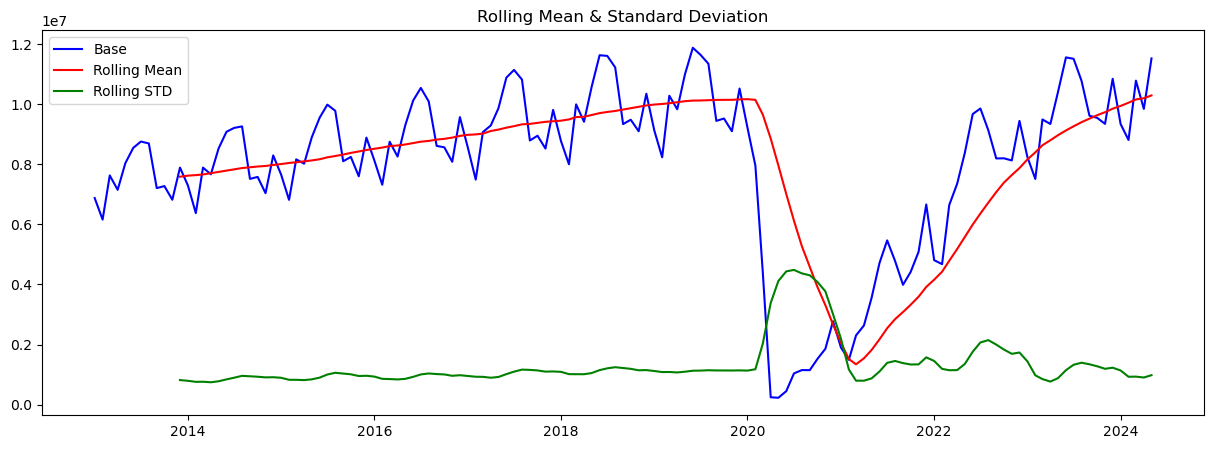

In [11]:
# check for stationarity visually
plt.figure(figsize=(15,5))
plt.plot(df_total, color='blue', label='Base')
plt.plot(M_mean, color='red', label='Rolling Mean')
plt.plot(M_STD, color='green', label='Rolling STD')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show()

By plotting the rolling mean and standard deviation, we can visually verify for stationarity. The rolling mean and standard deviation does not look to be constant; therefore, it looks to be non-stationary. We can further verify by using the Augmented Dickey-Fuller (ADF) test.

The ADF test uses the hypotheses test where the null hypotheses is that the time series model is non-stationary. Therefore, if the calculated p-value is less than 0.05 (5%) then the null hypotheses is rejected and the time series model is stationary. Also, if the resulting test statistic is less than the critical value then the null hypotheses can be rejected. For the function below, if these two conditions are met then it concludes that the time series model is stationary, else it is non-stationary.

In [ ]:
# function to check stationarity based on Augmented Dickey-Fuller test
def check_stationarity(ts):
    dftest = adfuller(ts)
    adf = dftest[0]
    pvalue = dftest[1]
    critical_value = dftest[4]['5%']
    if (pvalue < 0.05) and (adf < critical_value):
        return True
    else:
        return False

In [ ]:
check_stationarity(df_total['PASSENGERS'])

False

For a time series model to be evaluated, the model needs to be stationary. If the model is non-stationary, it will need to be differentiated to become stationary. Since this total passenger volume dataset is non-stationary, it's most likely the dataset for each destinations are non-stationary as well and will need to be differentiated. We will not get into differencing this dataset since it won't be used for modeling, rather we will differentiate the destinations later on.

A time series model is composed of three characteristics: trend, seasonal, and residue. We can decompose the total passenger volume dataset to verify our inference from earlier.

In [12]:
# decompose
decomp_total = tsa.seasonal_decompose(df_total, model='additive')
df_total['Trend']  = decomp_total.trend
df_total['Seasonal'] = decomp_total.seasonal
df_total['Residual'] = decomp_total.resid

In [24]:
# plot the decomposition
comps = ["Trend", "Seasonal", "Residual"]
fig = make_subplots(rows=3, cols=1, subplot_titles=comps)
for i, col in enumerate(comps):
    fig.add_trace(
        go.Scatter(x=df_total.index, y=df_total[col]),
        row=i+1,
        col=1
    )
fig.update_layout(height=600, width=1200, showlegend=False, title='Decomposition')
fig.show()

As inferred before, there is an upwards trend until about late 2019 and again from the recovery of COVID. The seasonal aspect is as concluded, yearly. The residual, which is a new component to us, doesn't seem to be completely random (other than the spike due to COVID). Ideally, the residuals need to be random like white noise else it's an indication that the model has not captured all the relevant information. Again, with the upwards trend and non-random residuals this dataset would require differencing to make it stationary.

Now that we have a general idea from the total passenger volume dataset, we can begin to look at our features or destinations.

### Decomposition

We will start by looking at the decomposition of each destination.

In [16]:
# decompose each destination in the main working dataframe
col = df_main.columns
df_decomp = {name: pd.DataFrame() for name in col}
for c in range(0,len(col)):
    decomp_dest = df_main[[col[c]]]
    decomp = tsa.seasonal_decompose(decomp_dest, model='additive')
    df_decomp[col[c]] = df_main[[col[c]]]
    df_decomp[col[c]].loc[:,['Trend']]  = decomp.trend
    df_decomp[col[c]].loc[:,['Seasonal']] = decomp.seasonal
    df_decomp[col[c]].loc[:,['Residual']] = decomp.resid

In [25]:
# plot the decomposition of all the destinations
city_name = list(df_decomp.keys())
comps = ["Trend", "Seasonal", "Residual"]

for n in range(len(city_name)):
    fig = make_subplots(rows=3, cols=1, subplot_titles=comps)
    for i, col in enumerate(comps):
        fig.add_trace(
            go.Scatter(x=df_decomp[city_name[n]].index, y=df_decomp[city_name[n]][col]),
            row=i+1,
            col=1
        )
    fig.update_layout(height=400, width=800, showlegend=False, title=city_name[n])
    fig.show()

Looking over the decomposition of the destinations, they have similar characteristics to that of the total passenger volume dataset. Trend looks to be upward, seasonal component is evident, and residual seems to be not completely random. With that in mind, we can check for stationarity.

### Stationarity

In [21]:
# check stationarity of the dataset
non_stationary = []
stationary = []
for all in range(len(df_main.columns)): # total target destinations
    cs = check_stationarity(df_main[df_main.columns[all]])
    if cs==False:
        non_stationary.append(df_main.columns[all])
    else:
        stationary.append(df_main.columns[all])
print(len(non_stationary))
non_stationary

50


['London, United Kingdom',
 'Toronto, Canada',
 'Tokyo, Japan',
 'Cancun, Mexico',
 'Mexico City, Mexico',
 'Frankfurt, Germany',
 'Seoul, South Korea',
 'Vancouver, Canada',
 'Sao Paulo, Brazil',
 'Montreal, Canada',
 'Amsterdam, Netherlands',
 'Calgary, Canada',
 'Guadalajara, Mexico',
 'San Jose, Costa Rica',
 'Dubai, United Arab Emirates',
 'Bogota, Colombia',
 'Santo Domingo, Dominican Republic',
 'Taipei, Taiwan',
 'San Jose del Cabo, Mexico',
 'Punta Cana, Dominican Republic',
 'Zurich, Switzerland',
 'San Salvador, El Salvador',
 'Puerto Vallarta, Mexico',
 'Ezeiza, Argentina',
 'Lima, Peru',
 'Aruba, Aruba',
 'Guatemala City, Guatemala',
 'Dublin, Ireland',
 'Port-au-Prince, Haiti',
 'Istanbul, Turkey',
 'Santiago, Chile',
 'Brussels, Belgium',
 'Manila, Philippines',
 'Monterrey, Mexico',
 'Santiago, Dominican Republic',
 'Liberia, Costa Rica',
 'Doha',
 'Delhi, India',
 'San Pedro Sula, Honduras',
 'Providenciales, Turks and Caicos Islands',
 'Belize City, Belize',
 'Quito, 

Initially, out of 61 destinations, 50 are non-stationary. First order of differencing will be applied to all the destinations since if they are stationary, they will remain stationary.

In [22]:
# 1st order differencing
df_diff1 = pd.DataFrame()
dest1 = df_main.columns
for d in range(len(dest1)):
    df_diff1[dest1[d]+'_DIFF'] = df_main[dest1[d]].diff(9)
df_diff1.dropna(inplace=True)

In [23]:
# 1st order differencing stationarity
non_stationary = []
stationary = []
diff = df_diff1.columns
for d in range(len(diff)):
    cs = check_stationarity(df_diff1[diff[d]])
    if cs==False:
        non_stationary.append(diff[d])
    else:
        stationary.append(diff[d])
print(len(non_stationary))
non_stationary

17


['London, United Kingdom_DIFF',
 'Toronto, Canada_DIFF',
 'Tokyo, Japan_DIFF',
 'Frankfurt, Germany_DIFF',
 'Seoul, South Korea_DIFF',
 'Amsterdam, Netherlands_DIFF',
 'Calgary, Canada_DIFF',
 'Panama City, Panama_DIFF',
 'Dubai, United Arab Emirates_DIFF',
 'Taipei, Taiwan_DIFF',
 'Tel Aviv, Israel_DIFF',
 'Madrid, Spain_DIFF',
 'Dublin, Ireland_DIFF',
 'Port-au-Prince, Haiti_DIFF',
 'Manila, Philippines_DIFF',
 'Doha_DIFF',
 'Quito, Ecuador_DIFF']

After first order of differencing, 17 destinations are non-stationary. Second order of differencing will be applied to these 17 destinations.

In [24]:
# 2nd order differencing
df_diff2 = pd.DataFrame()
dest2 = df_diff1.columns
for d in range(len(dest2)):
    df_diff2[dest2[d]] = df_diff1[dest2[d]].diff(6)
df_diff2.dropna(inplace=True)

In [25]:
# 2nd order differencing stationarity
non_stationary = []
stationary = []
diff = df_diff2.columns
for d in range(len(diff)):
    cs = check_stationarity(df_diff2[diff[d]])
    if cs==False:
        non_stationary.append(diff[d])
    else:
        stationary.append(diff[d])
print(len(non_stationary))
non_stationary

4


['Frankfurt, Germany_DIFF',
 'Seoul, South Korea_DIFF',
 'Sao Paulo, Brazil_DIFF',
 'Dubai, United Arab Emirates_DIFF']

After second order of differencing, 6 destinations remain non-stationary. Third order of differencing will be applied to these 6 destinations.

In [26]:
# 3rd order differencing
df_diff3 = pd.DataFrame()
dest3 = df_diff2.columns
for d in range(len(dest3)):
    df_diff3[dest3[d]] = df_diff2[dest3[d]].diff(3)
df_diff3.dropna(inplace=True)

In [27]:
# 3rd order differencing stationarity
non_stationary = []
stationary = []
diff = df_diff3.columns
for d in range(len(diff)):
    cs = check_stationarity(df_diff3[diff[d]])
    if cs==False:
        non_stationary.append(diff[d])
    else:
        stationary.append(diff[d])
print(len(non_stationary))
non_stationary

0


[]

Finally, after the third order of differencing, all destinations are stationary.

ARIMA model is composed of three non-seasonal components (p,d,q) where 'p' is the order of auto-regressive (AR), 'd' is the order of differencing (I), and 'q' is the order of moving average (MA). When seasonal components (P,D,Q,m) is added to the ARIMA model, it becomes a Seasonal ARIMA or SARIMA model where 'm' is the recurring fixed interval. <br>
We have just determined the order of differencing. Order of AR (p) and order of MA (q) can be determined from the autocorrelation and partial autocorrelation functions, respectively. The largest lag, other than at 0, outside of the blue shaded area, which represents non-significance, will determine the order of p and q.


### ACF and PACF Plots

We will use the stationary dataset which was accomplished after third order of differencing will be used to plot the ACF and PACF.

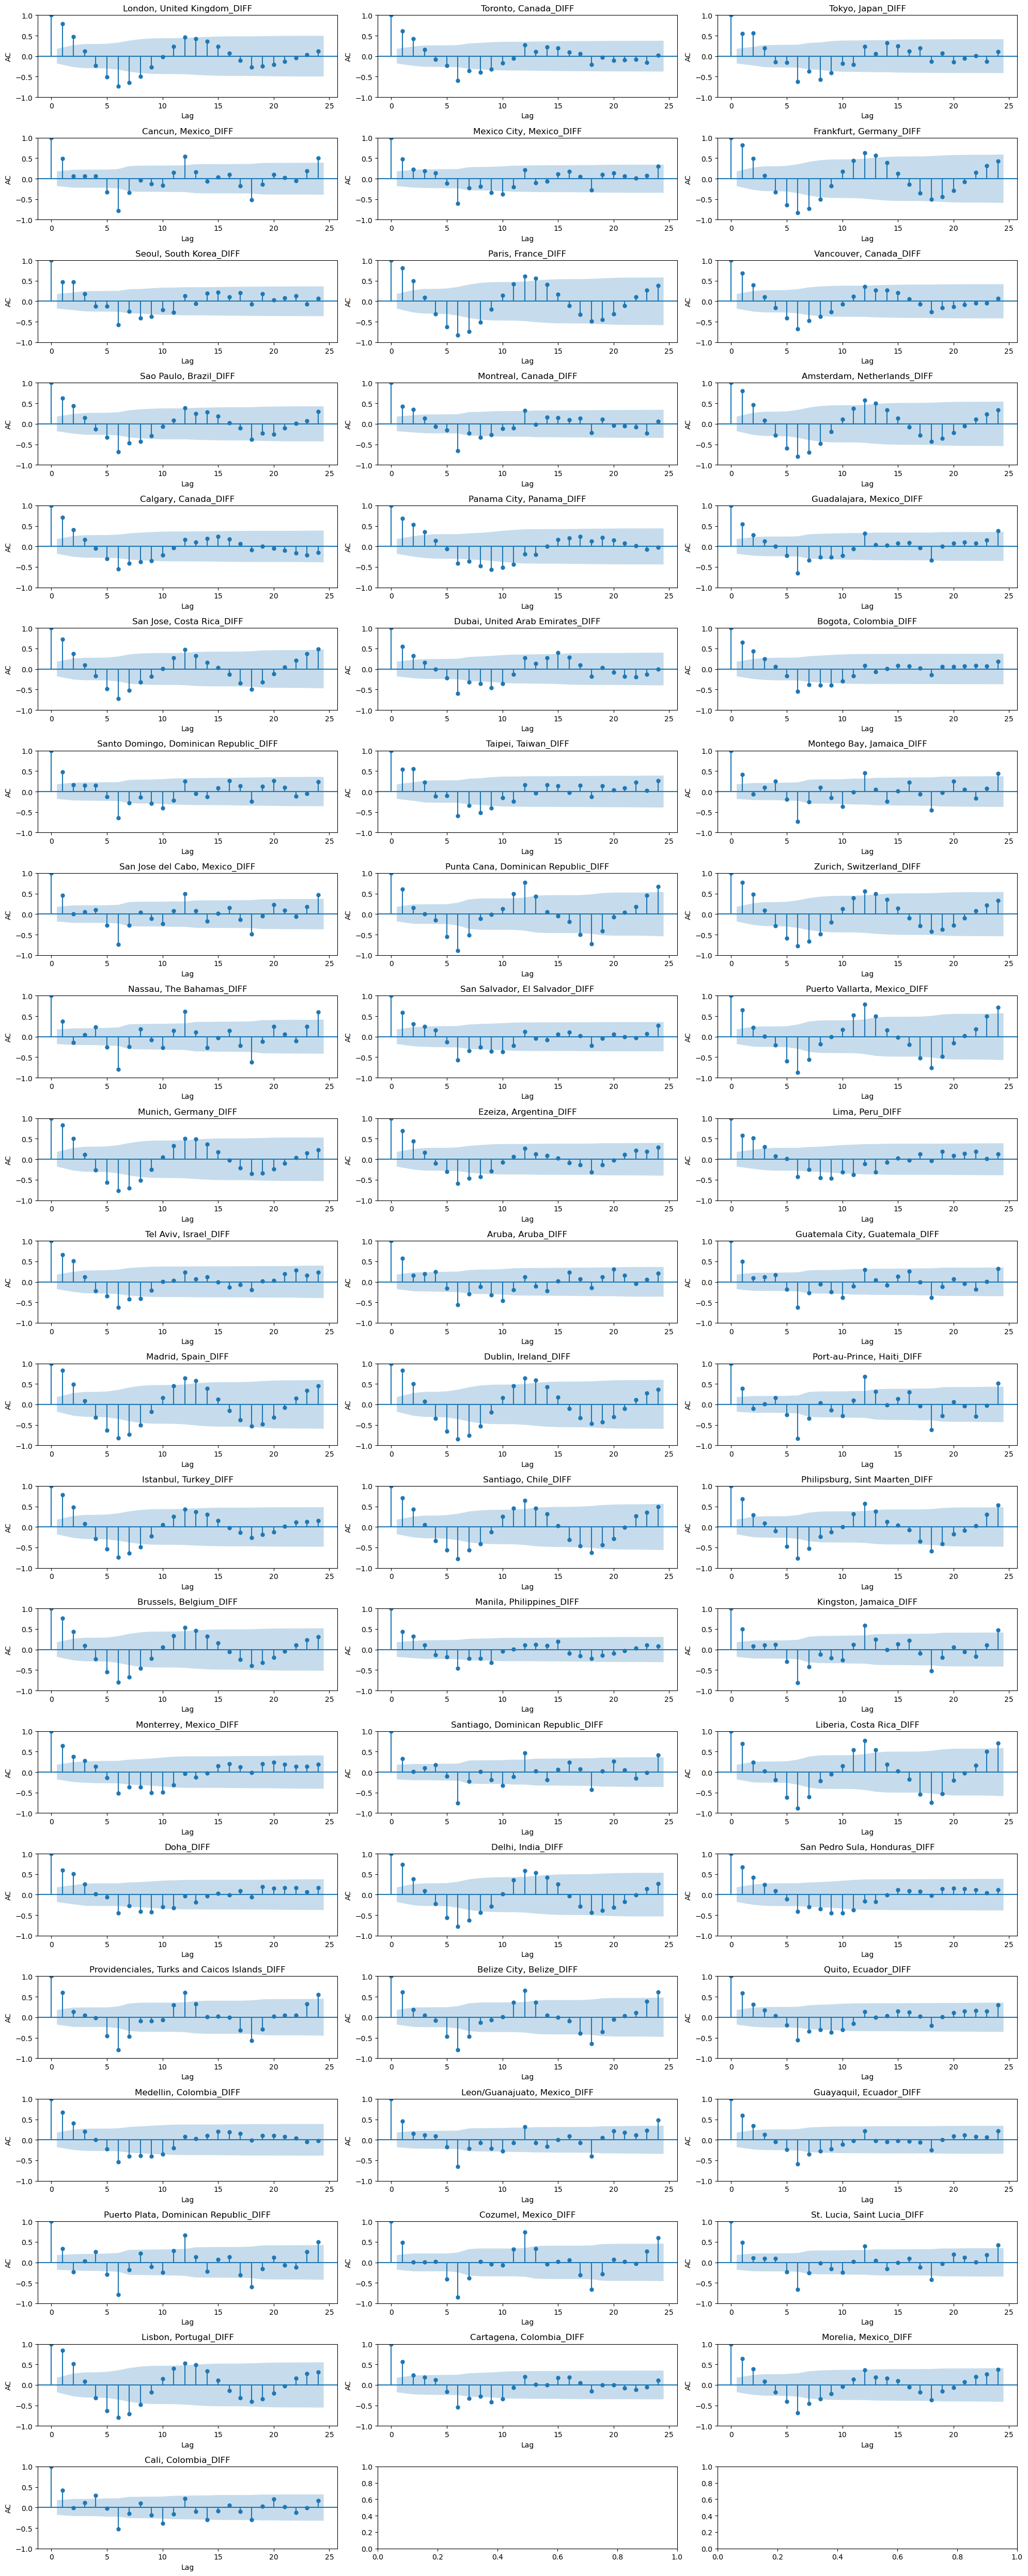

In [28]:
diff = df_diff3.columns
i = 1
plt.subplots(int(len(diff)/3)+1, 3, figsize=(20,50))

for d in diff:
    ax = plt.subplot(int(len(diff)/3)+1,3,i)
    plot_acf(df_diff3[d], lags=24, ax=ax)
    plt.title(d)
    plt.xlabel('Lag')
    plt.ylabel('AC')
    i+=1
    
plt.tight_layout()
plt.show()

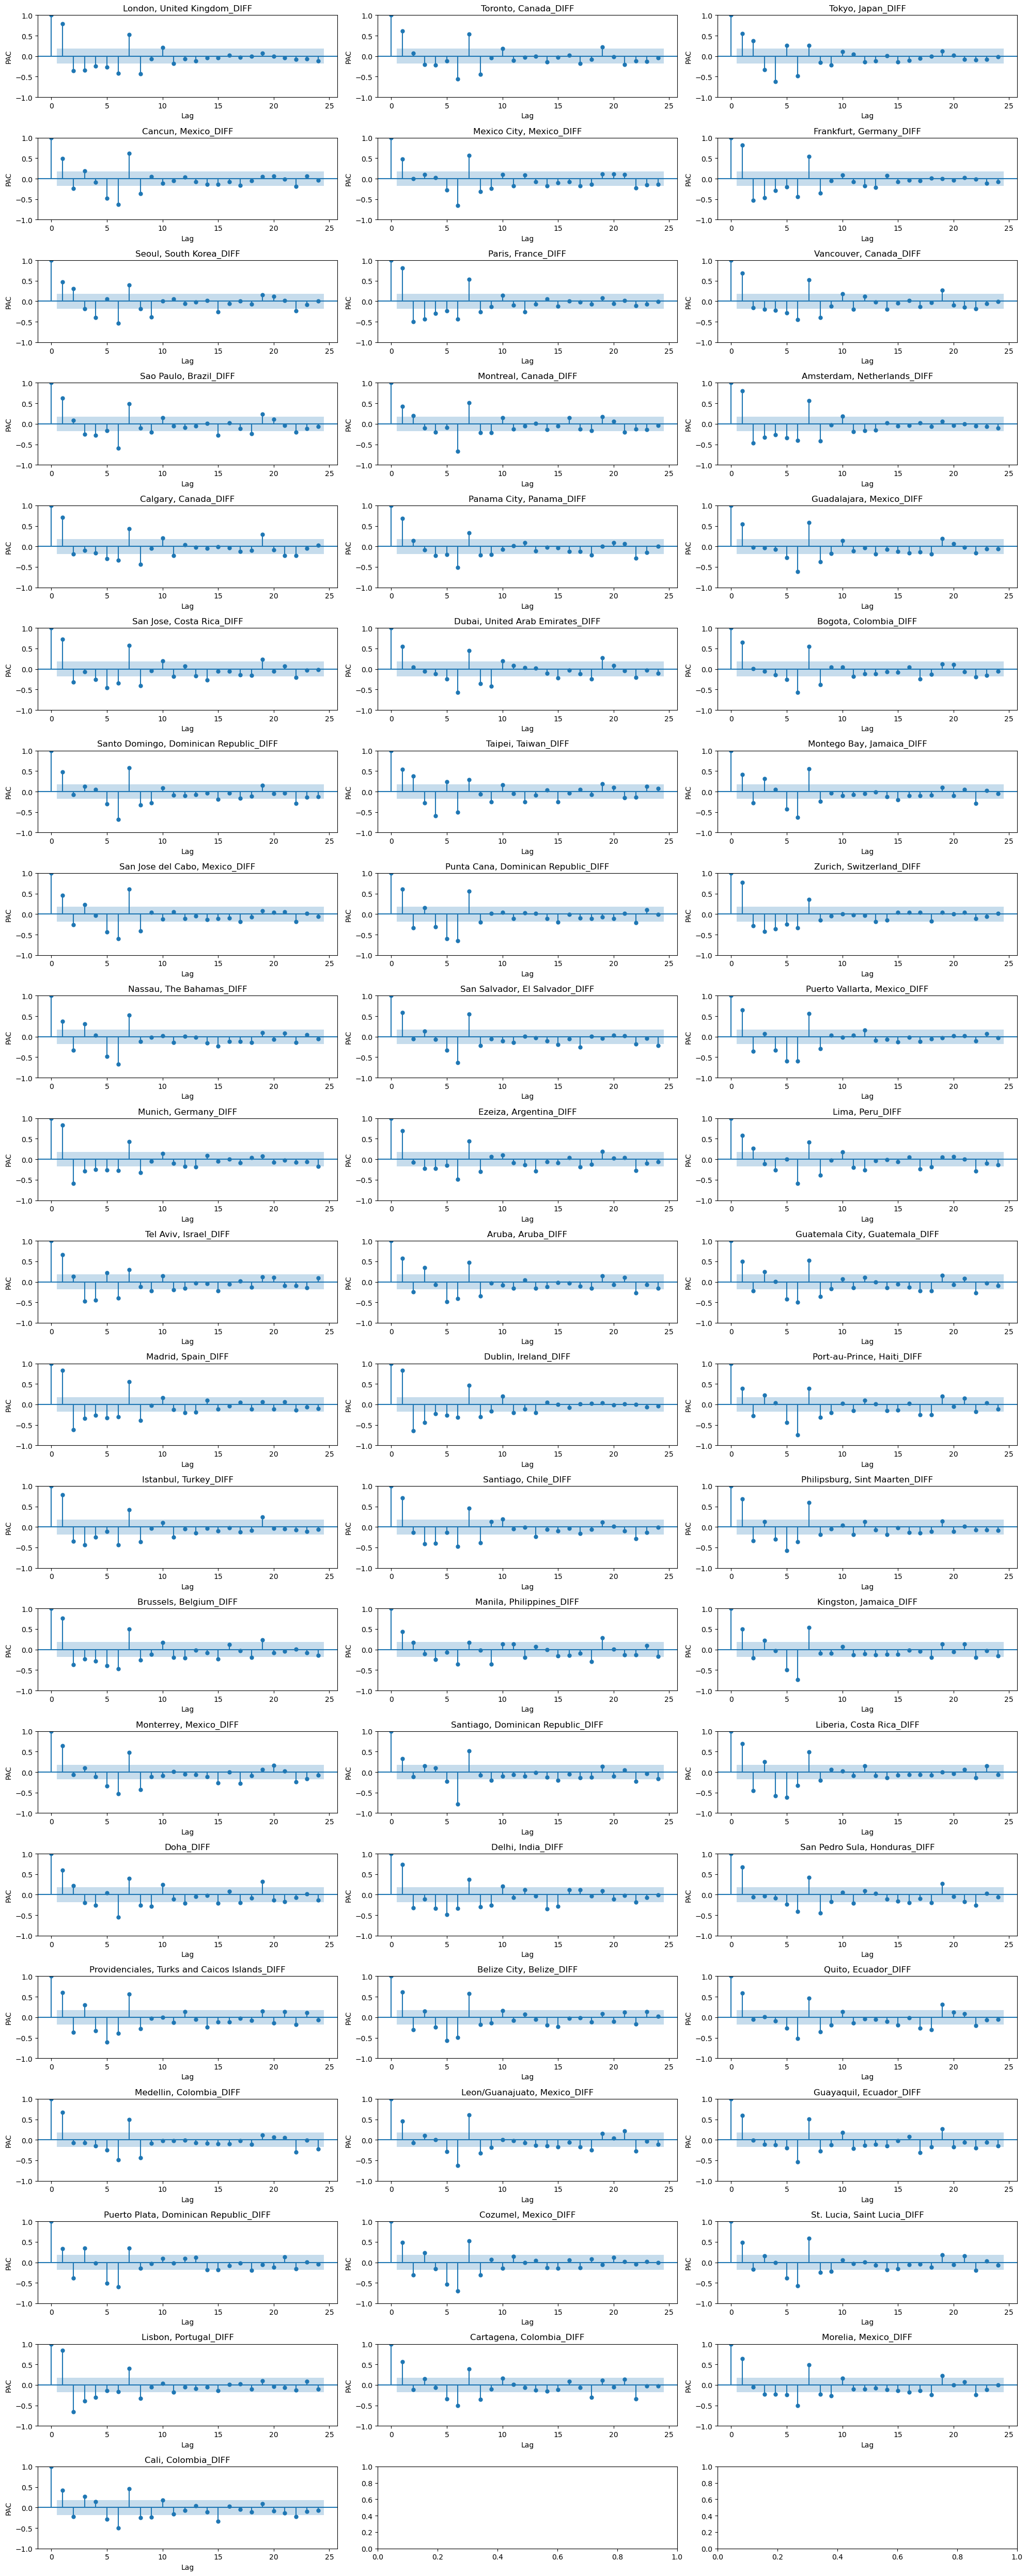

In [29]:
diff = df_diff3.columns
i = 1
plt.subplots(int(len(diff)/3)+1, 3, figsize=(20,50))

for d in diff:
    ax = plt.subplot(int(len(diff)/3)+1,3,i)
    plot_pacf(df_diff3[d], lags=24, ax=ax, method='ywm')
    plt.title(d)
    plt.xlabel('Lag')
    plt.ylabel('PAC')
    i+=1
    
plt.tight_layout()
plt.show()

Visually going through the ACF and PACF plots, the largest lag for ACF looks to be either at 1 or 2 and the largest lag for PACF looks to be at 1 or 7. We will keep this in mind moving forward onto the modeling phase.

### Conclusion / Next Steps
We have gone through the pre-processing to prepare for the SARIMA model. We have also performed feature engineering to transform the destinations as features and narrowed it down to 61 destinations to be inputted to the SARIMA model.
Three key aspects were determined through this pre-processing.
1. 3rd order of differencing was needed to make all the destinations stationary.
2. From the ACF model, the largest lag was at either 1 or 2.
3. From the PACF model, the largest lag was at either 1 or 7.

We will take these key aspects into account in the next step of the modeling phase.

Finally, the transformed and differentiated dataframes will be exported to use in the next step.

### Export Files

In [30]:
# export df_main
df_main.to_csv('capstone_df_main.csv')

# export df_main_diff
df_all_diff = df_diff3.copy()
df_all_diff.to_csv('capstone_df_main_diff.csv')

# export df_total
df_total.to_csv('capstone_df_total.csv')